In [15]:
import os
import json
import torch
import torch.nn as nn
import random
import copy
from PIL import Image
import matplotlib.pyplot as plt
from collections import defaultdict
from torch.utils.data import Dataset, DataLoader
from transformers import CLIPModel, CLIPProcessor

random.seed(100)

# load CLIP
clip_model = CLIPModel.from_pretrained("openai/clip-vit-base-patch32")
processor = CLIPProcessor.from_pretrained("openai/clip-vit-base-patch32")

# freeze!
for param in clip_model.parameters():
    param.requires_grad = False

# unfreeze attention pooling layer
for param in clip_model.vision_model.encoder.layers[-1].parameters():
    param.requires_grad = True

# print trainable parameters
for name, param in clip_model.named_parameters():
    if param.requires_grad:
        print("Will train:", name)

Will train: vision_model.encoder.layers.11.self_attn.k_proj.weight
Will train: vision_model.encoder.layers.11.self_attn.k_proj.bias
Will train: vision_model.encoder.layers.11.self_attn.v_proj.weight
Will train: vision_model.encoder.layers.11.self_attn.v_proj.bias
Will train: vision_model.encoder.layers.11.self_attn.q_proj.weight
Will train: vision_model.encoder.layers.11.self_attn.q_proj.bias
Will train: vision_model.encoder.layers.11.self_attn.out_proj.weight
Will train: vision_model.encoder.layers.11.self_attn.out_proj.bias
Will train: vision_model.encoder.layers.11.layer_norm1.weight
Will train: vision_model.encoder.layers.11.layer_norm1.bias
Will train: vision_model.encoder.layers.11.mlp.fc1.weight
Will train: vision_model.encoder.layers.11.mlp.fc1.bias
Will train: vision_model.encoder.layers.11.mlp.fc2.weight
Will train: vision_model.encoder.layers.11.mlp.fc2.bias
Will train: vision_model.encoder.layers.11.layer_norm2.weight
Will train: vision_model.encoder.layers.11.layer_norm2.b

In [16]:
with open("ground_truth_cn.json", "r") as f:
    ground_truth = json.load(f)

label_names = sorted(set(ground_truth.values()))
label2id = {name: idx for idx, name in enumerate(label_names)}
id2label = {idx: name for name, idx in label2id.items()}
NUM_CLASSES = len(label2id)

per_class_files = defaultdict(list)
for fname, cls in ground_truth.items():
    per_class_files[cls].append(fname)

train_files, val_files, test_files = [], [], []
for cls, files in per_class_files.items():
    files = list(files)
    random.shuffle(files)
    n = len(files)
    n_val = 2
    n_test = 2
    n_train = n - n_val - n_test
    val = files[:n_val]
    test = files[n_val:n_val+n_test]
    train = files[n_val+n_test:]
    val_files.extend(val)
    test_files.extend(test)
    train_files.extend(train)

gt_train = {k: ground_truth[k] for k in train_files}
gt_val = {k: ground_truth[k] for k in val_files}
gt_test = {k: ground_truth[k] for k in test_files}

In [17]:
class TrafficSignDataset(Dataset):
    def __init__(self, image_dir, ground_truth, label2id):
        self.image_dir = image_dir
        self.ground_truth = ground_truth
        self.label2id = label2id
        self.image_files = list(ground_truth.keys())

    def __len__(self):
        return len(self.image_files)

    def __getitem__(self, idx):
        fname = self.image_files[idx]
        label_name = self.ground_truth[fname]
        label_id = self.label2id[label_name]
        image_path = os.path.join(self.image_dir, fname)
        image = Image.open(image_path).convert("RGB")
        return image, label_id

def collate_fn(batch):
    images, labels = zip(*batch)
    return list(images), torch.tensor(labels)

image_folder = "cn"
processor = CLIPProcessor.from_pretrained("openai/clip-vit-base-patch32")

train_dataset = TrafficSignDataset(image_folder, gt_train, label2id)
val_dataset   = TrafficSignDataset(image_folder, gt_val, label2id)
test_dataset  = TrafficSignDataset(image_folder, gt_test, label2id)

train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True,  collate_fn=collate_fn)
val_loader   = DataLoader(val_dataset,   batch_size=16, shuffle=False, collate_fn=collate_fn)
test_loader  = DataLoader(test_dataset,  batch_size=16, shuffle=False, collate_fn=collate_fn)

In [18]:
class CLIPFineTuner(nn.Module):
    def __init__(self, clip_model, num_classes):
        super().__init__()
        self.clip = clip_model
        self.classifier = nn.Linear(clip_model.config.projection_dim, num_classes)

    def forward(self, pixel_values):
        features = self.clip.get_image_features(pixel_values=pixel_values)
        return self.classifier(features)

clip_model = CLIPModel.from_pretrained("openai/clip-vit-base-patch32")
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = CLIPFineTuner(clip_model, num_classes=NUM_CLASSES).to(device)

optimizer = torch.optim.AdamW(filter(lambda p: p.requires_grad, model.parameters()), lr=1e-5)
loss_fn = nn.CrossEntropyLoss()

In [19]:
num_epochs = 8
train_loss_hist, val_loss_hist, test_loss_hist = [], [], []
train_acc_hist, val_acc_hist, test_acc_hist = [], [], []

best_val_acc = 0.0
best_model_wts = copy.deepcopy(model.state_dict())

for epoch in range(num_epochs):
    # ---- train ----
    model.train()
    total_loss, total, correct = 0, 0, 0
    for images, labels in train_loader:
        inputs = processor(images=images, return_tensors="pt", padding=True).to(device)
        logits = model(inputs["pixel_values"])
        loss = loss_fn(logits, labels.to(device))

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        total_loss += loss.item() * labels.size(0)
        preds = logits.argmax(dim=1).cpu()
        correct += (preds == labels.cpu()).sum().item()
        total += labels.size(0)
    train_loss = total_loss / total
    train_acc = correct / total
    train_loss_hist.append(train_loss)
    train_acc_hist.append(train_acc)

    # ---- validation ----
    model.eval()
    val_loss, val_total, val_correct = 0, 0, 0
    with torch.no_grad():
        for images, labels in val_loader:
            inputs = processor(images=images, return_tensors="pt", padding=True).to(device)
            logits = model(inputs["pixel_values"])
            loss = loss_fn(logits, labels.to(device))
            val_loss += loss.item() * labels.size(0)
            preds = logits.argmax(dim=1).cpu()
            val_correct += (preds == labels.cpu()).sum().item()
            val_total += labels.size(0)
    val_loss = val_loss / val_total
    val_acc = val_correct / val_total
    val_loss_hist.append(val_loss)
    val_acc_hist.append(val_acc)

    # ---- test ----
    test_loss, test_total, test_correct = 0, 0, 0
    with torch.no_grad():
        for images, labels in test_loader:
            inputs = processor(images=images, return_tensors="pt", padding=True).to(device)
            logits = model(inputs["pixel_values"])
            loss = loss_fn(logits, labels.to(device))
            test_loss += loss.item() * labels.size(0)
            preds = logits.argmax(dim=1).cpu()
            test_correct += (preds == labels.cpu()).sum().item()
            test_total += labels.size(0)
    test_loss = test_loss / test_total
    test_acc = test_correct / test_total
    test_loss_hist.append(test_loss)
    test_acc_hist.append(test_acc)

    print(f"Epoch {epoch+1}/{num_epochs}: "
          f"Train Loss/Acc={train_loss:.4f}/{train_acc:.4f} | "
          f"Val Loss/Acc={val_loss:.4f}/{val_acc:.4f} | "
          f"Test Loss/Acc={test_loss:.4f}/{test_acc:.4f}")

    # save best weights
    if val_acc > best_val_acc:
        best_val_acc = val_acc
        best_model_wts = copy.deepcopy(model.state_dict())

# restore best model weights
model.load_state_dict(best_model_wts)

Epoch 1/8: Train Loss/Acc=2.8934/0.4329 | Val Loss/Acc=2.4191/0.7333 | Test Loss/Acc=2.4033/0.7833
Epoch 2/8: Train Loss/Acc=1.7023/0.9451 | Val Loss/Acc=1.5046/0.9167 | Test Loss/Acc=1.4838/0.8667
Epoch 3/8: Train Loss/Acc=0.9161/0.9878 | Val Loss/Acc=0.9403/1.0000 | Test Loss/Acc=0.9186/0.9667
Epoch 4/8: Train Loss/Acc=0.5197/1.0000 | Val Loss/Acc=0.6014/1.0000 | Test Loss/Acc=0.6218/0.9667
Epoch 5/8: Train Loss/Acc=0.3260/1.0000 | Val Loss/Acc=0.4315/1.0000 | Test Loss/Acc=0.4443/0.9833
Epoch 6/8: Train Loss/Acc=0.2285/1.0000 | Val Loss/Acc=0.3359/0.9833 | Test Loss/Acc=0.3492/0.9833
Epoch 7/8: Train Loss/Acc=0.1730/1.0000 | Val Loss/Acc=0.2770/0.9833 | Test Loss/Acc=0.2896/0.9833
Epoch 8/8: Train Loss/Acc=0.1402/1.0000 | Val Loss/Acc=0.2405/0.9833 | Test Loss/Acc=0.2549/0.9833


<All keys matched successfully>

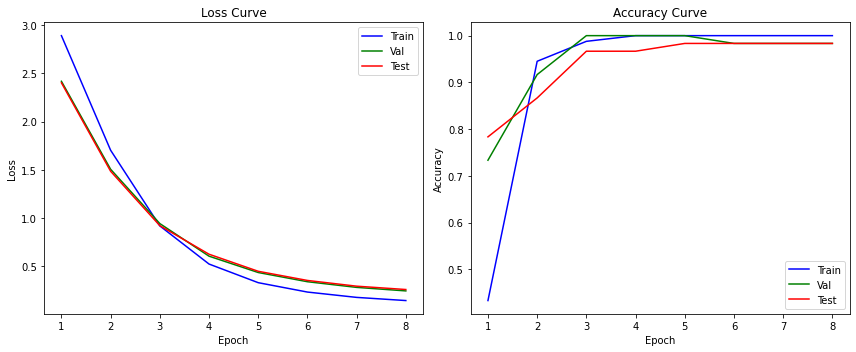

In [20]:
epochs = range(1, num_epochs + 1)
plt.figure(figsize=(12,5))

plt.subplot(1,2,1)
plt.plot(epochs, train_loss_hist, label="Train", color='b')
plt.plot(epochs, val_loss_hist, label="Val", color='g')
plt.plot(epochs, test_loss_hist, label="Test", color='r')
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Loss Curve")
plt.legend()

plt.subplot(1,2,2)
plt.plot(epochs, train_acc_hist, label="Train", color='b')
plt.plot(epochs, val_acc_hist, label="Val", color='g')
plt.plot(epochs, test_acc_hist, label="Test", color='r')
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.title("Accuracy Curve")
plt.legend()

plt.tight_layout()
plt.show()

In [21]:
torch.save(model.state_dict(), "clip_finetuned.pth")